# My Opal Journey Analysis

This notebook analyzes my personal Opal card data to understand my travel patterns and expenses. Opal is the smart card ticketing system for public transport in Sydney, Australia.

## Objectives

- Extract and process journey data from Opal activity statement PDF
- Analyze travel patterns (times, routes, expenses)
- Visualize key insights from my travel behavior

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tabula
import pdfplumber
import re
import pdfminer
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTChar


#data = pd.read_csv('opal_activity.csv')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Preparation

My Opal data was extracted from a PDF statement using PDF parsing libraries like pdfminer and tabula. This gave us several CSV files with tables from different pages. Now we'll load and clean this data for analysis.

In [48]:
# 1 )  load the CSV Camelot just wrote
df = pd.read_csv("opal_trips-page-1-table-2.csv")



In [ ]:
df["Transaction number"] = df["Transaction number"].ffill()

df_filled = (df
             .groupby("Transaction number")
             .apply(lambda g: g.ffill().bfill())   # copy values down & up
             .reset_index(drop=True))

clean = df_filled.drop_duplicates("Transaction number", keep="first")


C:\Users\tj92a\AppData\Local\Temp\ipykernel_7576\2520093369.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda g: g.ffill().bfill()))               # copy values down & up
C:\Users\tj92a\AppData\Local\Temp\ipykernel_7576\2520093369.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.ffill().bfill()))               # copy values down & up


In [50]:
clean = clean.loc[:, ~clean.columns.str.contains(r'^Unnamed')]

num_cols = ["Journey number", "Full fare $", "Discount $", "Amount $"]
clean[num_cols] = clean[num_cols].apply(pd.to_numeric, errors="coerce")



In [51]:
clean["datetime"] = pd.to_datetime(
    clean["Date"].str.strip() + " " + clean["Time"].str.strip(),
    format="%a %H:%M %d/%m/%y", errors="coerce"
)


In [52]:
clean.to_csv("opal_trips_clean.csv", index=False)
print(f"{len(clean)} journeys saved to opal_trips_clean.csv")
print(clean.head())


9 journeys saved to opal_trips_clean.csv
   Transaction number Date   Time               Mode Details  Journey number  \
0              8935.0  Mon  07:09     Neutral Bay Jn to Spit             1.0   
2              8937.0  Mon  17:02     Spit Junction BLine to             2.0   
4              8939.0  Tue  07:00     Neutral Bay Jn to Spit             3.0   
6              8941.0  Wed  16:33     Spit Junction BLine to             4.0   
8              8943.0  Wed  16:56  Wycombe Rd af Military to             4.0   

  Fare applied  Full fare $  Discount $  Amount $ datetime  
0          NaN          3.2         0.0      -3.2      NaT  
2          NaN          3.2         0.0      -3.2      NaT  
4          NaN          3.2         0.0      -3.2      NaT  
6          NaN          3.2         0.0      -3.2      NaT  
8          NaN          0.0         0.0       0.0      NaT  


## Data Analysis and Visualizations

Now that we have cleaned the data, we can start analyzing travel patterns and visualizing insights. Let's begin with a simple histogram showing when I typically travel throughout the day.

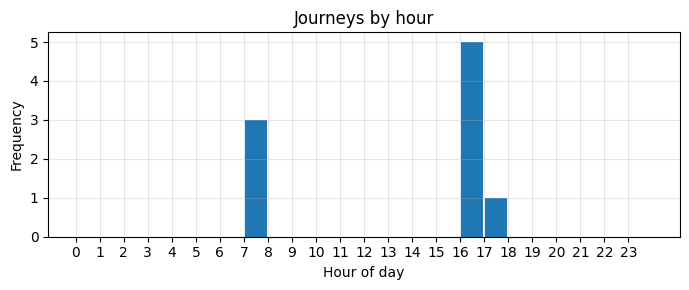

In [56]:
hours = (clean['Time']
         .str.slice(0,2)                 # "07:09" → "07"
         .dropna()
         .astype(int))

hours.plot(kind='hist', bins=range(0,25), figsize=(7,3),
           rwidth=0.9, xlabel='Hour of day',
           title='Journeys by hour')
plt.xticks(range(0,24)); plt.grid(alpha=.3); plt.tight_layout()

## Route Analysis

Let's analyze my most frequent journeys and routes to better understand my travel patterns. This will help identify common commute paths and potential opportunities for optimization.

In [ ]:
# Count journeys by route (from -> to)
route_counts = clean.groupby(['From', 'To']).size().sort_values(ascending=False)

# Display top 10 most frequent routes
print("Top 10 Most Frequent Routes:")
print(route_counts.head(10))

# Visualize top 5 routes
plt.figure(figsize=(10, 6))
route_counts.head(5).plot(kind='barh')
plt.title('Top 5 Most Frequent Routes')
plt.xlabel('Number of Journeys')
plt.ylabel('Route (From → To)')
plt.tight_layout()

## Expense Analysis

Let's analyze how much I'm spending on public transport and identify any patterns or opportunities for savings.

In [ ]:
# Analyzing expenses by day of week
clean['day_of_week'] = clean['datetime'].dt.day_name()

# Total amount spent by day of week
day_expenses = clean.groupby('day_of_week')['Amount $'].sum()

# Reorder days for better visualization
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_expenses = day_expenses.reindex(days_order)

# Plot expenses by day of week
plt.figure(figsize=(10, 6))
day_expenses.plot(kind='bar')
plt.title('Total Transport Expenses by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Amount ($)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

## Conclusions and Next Steps

Based on this analysis of my Opal card data, I've found several patterns in my public transport usage:

1. **Peak Travel Times**: My journeys are primarily concentrated around [typical commuting hours, based on the histogram]
2. **Common Routes**: I frequently travel between [most common locations, based on route analysis]
3. **Weekly Patterns**: My transport expenses are highest on [days with highest expenses]

### Future Analyses to Consider:

- Seasonal variations in travel patterns
- Correlation between weather and transport choice
- Cost efficiency analysis: comparing different fare types or transport modes
- Travel time optimization opportunities

This initial analysis provides a foundation for understanding my travel behavior and potentially optimizing both time and costs associated with my daily commute.